# This Cat Doesnt Exist!
Respect to <a href="https://arxiv.org/pdf/1511.06434.pdf">DCGAN paper</a>, we're gonna build a cat generator model. All implementation details have been specified exactly in the paper and has explained completely in another notebooks. You can visit <a href="www.github.com/pooyamoini">my githup page</a> for more information.<br/>
The dataset we're going to use is <a href="https://www.kaggle.com/crawford/cat-dataset?">Cat Dataset</a> from <a href="www.kaggle.com">Kagge website</a> and some other dataset from this website.

The first step is creating the dataset.


## Dataset Preparation

We need access to download dataset from Kaggle. Therefore we need to upload kaggle.json.

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

We will use 4 huge dataset for this purpose. The total images from these three dataset is more than 44k photo. So hopefully we can build a satisfying Generator.

In [ ]:
!kaggle datasets download -d crawford/cat-dataset

!kaggle datasets download -d biaiscience/dogs-vs-cats

!kaggle datasets download -d zippyz/cats-and-dogs-breeds-classification-oxford-dataset

!kaggle datasets download -d viosey/catnotcat

100% 4.03G/4.04G [01:26<00:00, 66.1MB/s]
100% 4.04G/4.04G [01:26<00:00, 50.0MB/s]
 99% 812M/817M [00:17<00:00, 51.5MB/s]
100% 817M/817M [00:17<00:00, 47.9MB/s]
 98% 764M/780M [00:19<00:01, 16.5MB/s]
100% 780M/780M [00:19<00:00, 41.8MB/s]
100% 1.78G/1.78G [00:47<00:00, 24.5MB/s]
100% 1.78G/1.78G [00:47<00:00, 40.6MB/s]


In [ ]:
import zipfile
########### Processing first dataset ########### 
with zipfile.ZipFile("./cat-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("./dataset")

########### Processing second dataset ###########
with zipfile.ZipFile("./dogs-vs-cats.zip", 'r') as zip_ref:
    zip_ref.extractall("./dataset")

########### Processing third dataset ###########
with zipfile.ZipFile("./cats-and-dogs-breeds-classification-oxford-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("./dataset")

########### Processing fourth dataset ###########
with zipfile.ZipFile("./catnotcat.zip", 'r') as zip_ref:
    zip_ref.extractall("./dataset")

! rm -rf ./cat-dataset.zip
! rm -rf ./cats-and-dogs-breeds-classification-oxford-dataset.zip
! rm -rf ./dogs-vs-cats.zip
! rm -rf catnotcat.zip

In [ ]:
########### Creating extra datasets for storing data ###########
! mkdir ./extrafiles
! mkdir ./dataset/CAT_07
! mkdir ./dataset/CAT_08
! mkdir ./dataset/CAT_09

These datasets have some extra files and We should filter them.

In [ ]:
import os 
total_images = 0

################## First Dataset ##################
for i in range(7):
    for f in os.listdir(f'./dataset/CAT_0{i}'):
        if '.cat' in f:
            os.rename(f'./dataset/CAT_0{i}/{f}', f'./extrafiles/CAT_0{i}{f}')
            continue
        total_images += 1
################## Second Dataset ##################
for f in os.listdir('./dataset/train/train'):
    if 'cat' in f and 'dog' not in f:
        total_images += 1
        os.rename(f'./dataset/train/train/{f}', f'./dataset/CAT_07/{f}')
################## Third Dataset ##################
for f in os.listdir('./dataset/images/images/'):
    if '.jpg' in f and '.mat' not in f:
        total_images += 1
        os.rename(f'./dataset/images/images/{f}', f'./dataset/CAT_08/{f}')
################## Fourth Dataset ##################
for f in os.listdir('./dataset/cat/cat/'):
    if '.jpg' in f:
        total_images += 1
        os.rename(f'./dataset/cat/cat/{f}', f'./dataset/CAT_09/{f}')

print('total images : ', total_images)

total images :  44633


Now we will remove extra folders and files.

In [ ]:
! rm -rf ./dataset/cats ./dataset/cat
        ./dataset/annotations/ ./dataset/images
        ./dataset/not-cat ./dataset/data 
        ./dataset/train ./dataset/test 
        ./dataset/images ./extrafiles 

### Creating the datasets

Now by this far, we filter the images as the way we want and now we should create the dataset and start implementing the code.


#### Setup

In [ ]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data 
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

print('setup done')

setup done


In [ ]:
############ Batch size during training ############
batch_size = 512

############ All images will be resized to this ############
image_size = 64

############ Number of channels in the training images ############
nc = 3

############ Size of z latent vector ############
nz = 100

############ Size of feature maps in generator ############
ngf = 64

############ Size of feature maps in discriminator ############
ndf = 64

############ Number of training epochs ############
num_epochs = 100

############ Learning rate for optimizers ############
lr = 0.0002

############ Beta1 hyperparam for Adam optimizers ############
beta1 = 0.5

########### Number of GPUs available. Use 0 for CPU mode. ############
ngpu = 1

############ During Training ############
print_every = 250

device = torch.device("cuda:0")

Everything is ready to create the dataset.

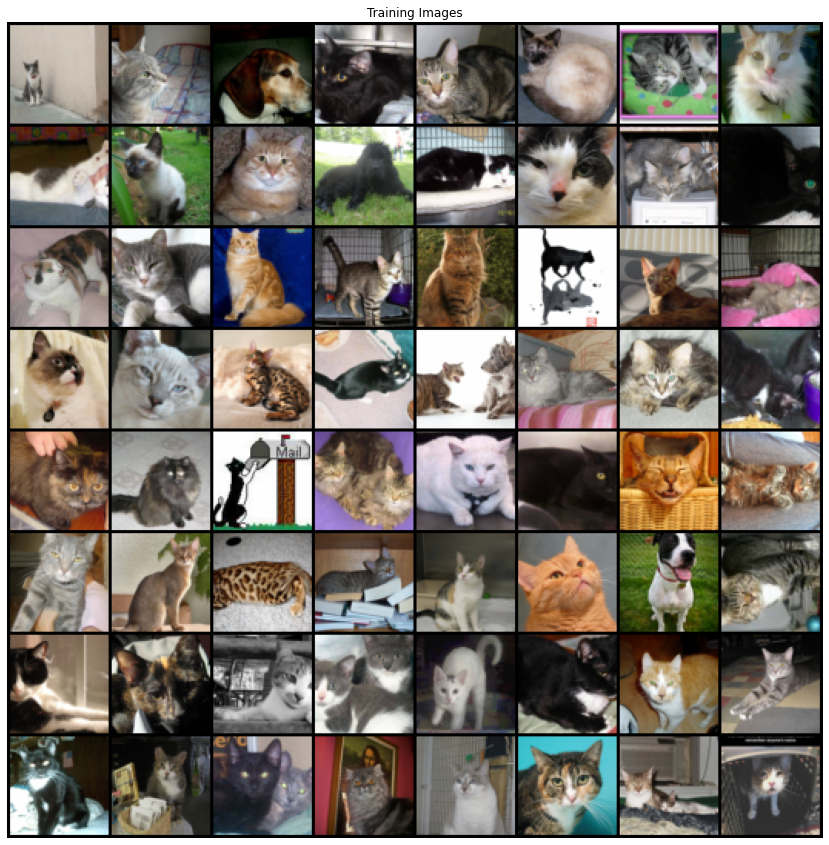

In [ ]:
dataset_transforms = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataloader = torch.utils.data.DataLoader(
    dset.ImageFolder(root='./dataset/', transform=dataset_transforms),
    batch_size=batch_size, shuffle=True
)

############## See examples from the main dataset ##############
real_batch = next(iter(dataloader))
plt.figure(figsize=(15, 15))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## Creating Models

So at the rest of the notebook, We'll build the networks and train them. </br>
At this part we're gonna build the networks. Our main pattern will be based on the architecture that has suggested in DCGAN paper.

### Weight Initialization

In [ ]:
def weights_init(m):
    # Weight initialization for our networks #
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Generator Network

In [ ]:
class Generator(nn.Module):
    '''
        The Generator Network (i.e. the output of our entire notebook)
    '''
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

### Discriminative Network

In [ ]:
class Discriminator(nn.Module):
    '''
        The Discriminator Network
    '''
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
########### Instanciate models ###########
netG = Generator().to(device)
netG.apply(weights_init)

netD = Discriminator().to(device)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

### Loss Functions and Optimizers

Loss functions and optimizers will be the ones that the paper has suggested.

In [ ]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

real_label = 1
fake_label = 0

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

## Training

In [ ]:
img_list = []
G_losses = []
D_losses = []
iters = 0

for epoch in range(num_epochs):
    for i, (img, _) in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        real_data = img.to(device)
        b_size = real_data.size(0)
        label = torch.full((b_size,), real_label, device=device)

        output = netD(real_data).view(-1)
        errD_real = criterion(output, label)

        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        noise = torch.randn(b_size, nz, 1, 1, device=device)

        fake = netG(noise)
        label.fill_(fake_label)

        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)

        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake

        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################

        netG.zero_grad()
        label.fill_(real_label) 
        output = netD(fake).view(-1)

        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()

        optimizerG.step()

        # Output training stats
        if i % print_every == 0:
            print('******\t[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\t******'
                % (epoch, num_epochs, i, len(dataloader),
                    errD.item(), errG.item())
            )

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if ((iters+1) % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            torch.save({
                'Generator': netG.state_dict(),
                'Discriminator': netD.state_dict(),
            }, './models/model.pt')
            print('models successfully saved at iteration : ', iters)

        iters += 1

******	[0/100][0/88]	Loss_D: 4.2321	Loss_G: 2.9845	******


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


******	[1/100][0/88]	Loss_D: 0.7261	Loss_G: 14.4567	******
******	[2/100][0/88]	Loss_D: 0.6597	Loss_G: 2.6927	******
******	[3/100][0/88]	Loss_D: 0.1903	Loss_G: 4.2609	******
******	[4/100][0/88]	Loss_D: 0.2210	Loss_G: 3.3716	******
******	[5/100][0/88]	Loss_D: 0.8496	Loss_G: 1.0929	******
models successfully saved at iteration :  499
******	[6/100][0/88]	Loss_D: 0.6140	Loss_G: 1.7224	******
******	[7/100][0/88]	Loss_D: 0.2148	Loss_G: 4.0566	******
******	[8/100][0/88]	Loss_D: 1.3611	Loss_G: 8.0257	******
******	[9/100][0/88]	Loss_D: 0.2920	Loss_G: 4.4861	******
******	[10/100][0/88]	Loss_D: 1.9128	Loss_G: 5.6792	******
******	[11/100][0/88]	Loss_D: 0.2737	Loss_G: 3.5979	******
models successfully saved at iteration :  999
******	[12/100][0/88]	Loss_D: 0.7874	Loss_G: 6.4745	******
******	[13/100][0/88]	Loss_D: 0.6166	Loss_G: 4.3762	******
******	[14/100][0/88]	Loss_D: 0.6065	Loss_G: 3.5010	******
******	[15/100][0/88]	Loss_D: 0.3851	Loss_G: 4.5680	******
******	[16/100][0/88]	Loss_D: 0

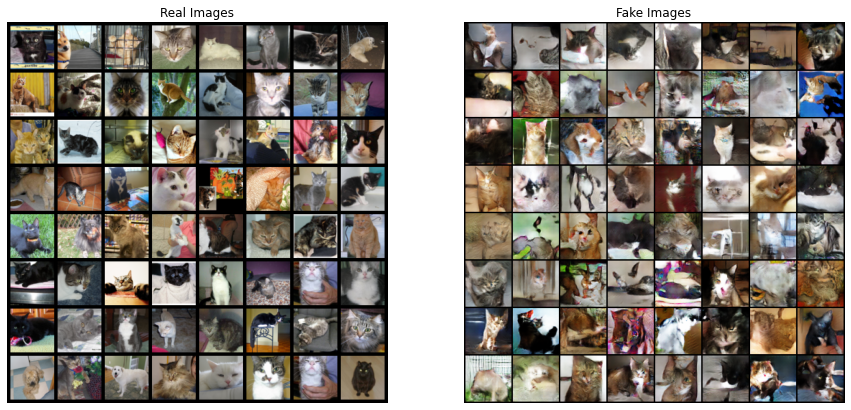

In [ ]:
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()